# Initial Value Problems (Ordinary Differential Equations) - Chapter 17, McClarren

In this chapter we will use numerical integration techniques to solve ordinary differential
equations (ODEs) where the value of the solution is specified at a single value of the independent
variable. Because these problems often correspond to time-dependent problems with
an initial condition, these are called initial value problems.

Consider the generic, initial value problem with a first-order derivative given by

$$ y'(t) = f(y,t), \qquad y(0)=y_0, $$

where $f(y,t)$ is a function that in general depends on $y$ and $t$.  Typically, we call $t$ the time
variable and $y$ our solution. For a problem of this sort we can simply integrate both sides of
the equation from $t = 0$ to $t = \Delta t$, where $\Delta t$ is called the time step. Doing this we get 

$$ y(\Delta t) - y(0) = \int\limits_0^{\Delta t} f(y,t) dt. $$

## Forward Euler

To proceed we will treat the integral in the previous equation using a numerical integration
rule. One rule that is so basic we did not talk about in the chapters on numerical integration
is the left-hand rectangle rule. Here we estimate the integral as

$$\int\limits_0^{\Delta t} f(y,t) dt \approx \Delta t f(y(0),0). $$

Using this relation gives us:

$$y(\Delta t) = y(0) + \Delta t f(y(0),0). $$

This will give an approximate value of the solution $\Delta t$ after the initial condition. If we wanted
to continue out to later times, we could apply the rule again repeatedly. To do this we define
the value of $y$ after $n$ timesteps, each of width $\Delta t$ as

$$ y^n = y(t^n) = y(n \Delta t), \qquad \texttt{for } n=0, \cdots, N.$$

Using this we can write the solution using the left-hand rectangle rule for integration as

$$y^{n+1} = y^n + \Delta t f(y^n,t^n). $$

This method is called the *explicit Euler method* or the *forward Euler method* after the Swiss
mathematician whose name is commonly pronounced *oi-ler*, much like a hockey team from
Edmonton. The method is said to be explicit, not because sometimes it will make you want
to shout profanity, rather that the update is explicitly defined by the value of the solution at
time $t^n$. Below we define a Python function that for a given right-hand side, initial condition,
and time step and number of time steps, $N$, performs the forward Euler method. This function
will take the name of the function on the right-hand side as an input.

In [1]:
def forward_euler(f,y0,Delta_t,numsteps):
    """Perform numsteps of the forward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        y[n] = y[n-1] + Delta_t * f(y[n-1], t[n-1])
    return t, y

We will test this on a simple problem:

$$y'(t) =- y(t), \qquad y_0 = 1. $$

The solution to this problem is 

$$ y(t) = e^{-t}.$$

The following code compares the exact solution to the forward Euler solution with a time
step of 0.1.

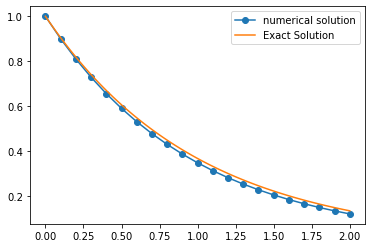

In [2]:
import numpy as np
import matplotlib.pyplot as plt
RHS = lambda y,t: -y
Delta_t = 0.1
t_final = 2.0
t,y = forward_euler(RHS,1,Delta_t,t_final/Delta_t)
plt.plot(t,y,'o-',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.exp(-t_fine),label="Exact Solution")
plt.legend()

That looks pretty close. The numerical solution appears to be slightly below the exact solution, but the difference appears to be small. We could re-do this with different size time steps and compare the solutions as a function of $t$.

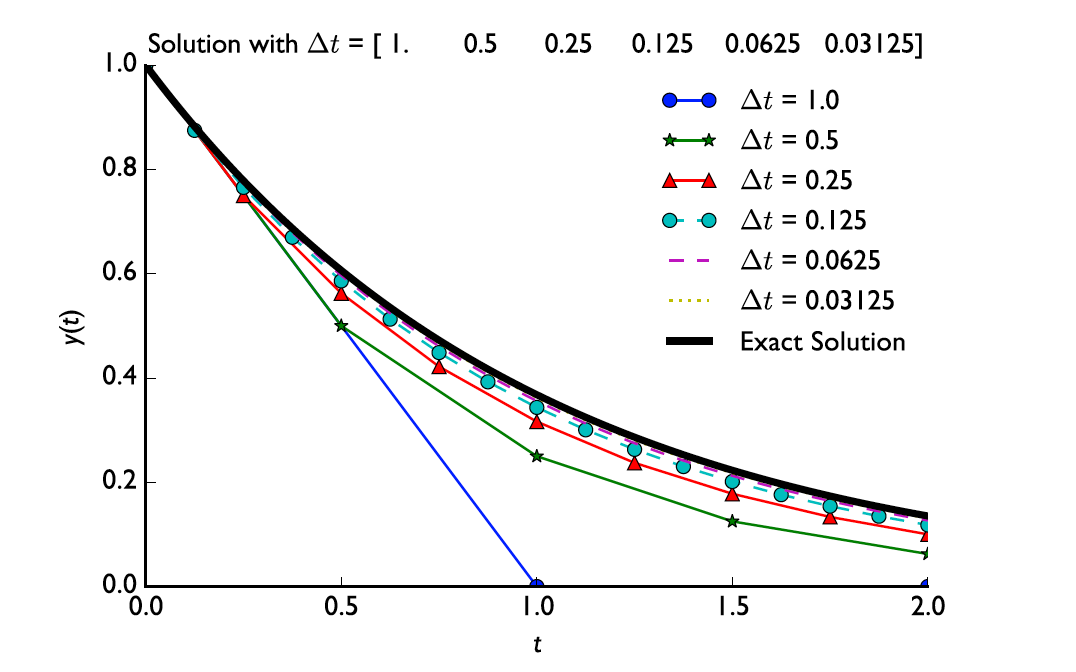

Also, we can compute the error as a function of $t$. On a log-log scale this will tell us about the convergence of this method in $t$.

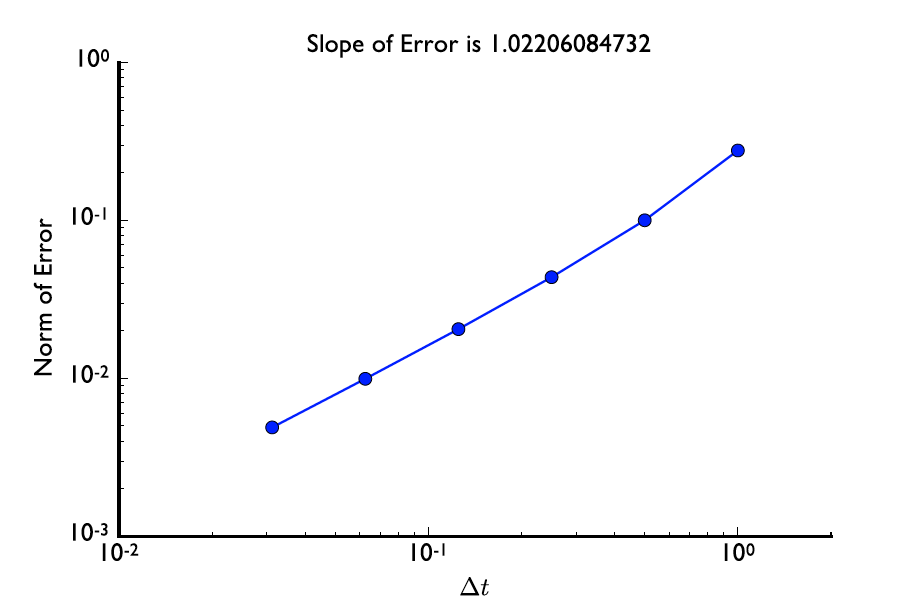

Notice that the error indicates that this is a first-order method in 
$\Delta t$: when we decrease $\Delta t$
by a factor of 2, the error decreases by a factor of 2. In this case we measured the error with a slightly different error norm:

$$\texttt{Error} = \frac{1}{\sqrt{N}} \sqrt{\sum\limits_{n=1}^N \left(y_{\texttt{approx}}^n - y_{\texttt{exact}}^n \right)^2} $$

where $N$ is the number of steps the ODE is solved over.
One thing that can happen with the forward Euler method is that if the time step is too
large, it can become unstable. What this means is the solution diverges to be plus or minus infinity (sometimes it goes to both). In our case, forward Euler is unstable if 
$\Delta t > 2$, as we will prove later and demonstrate numerically here.

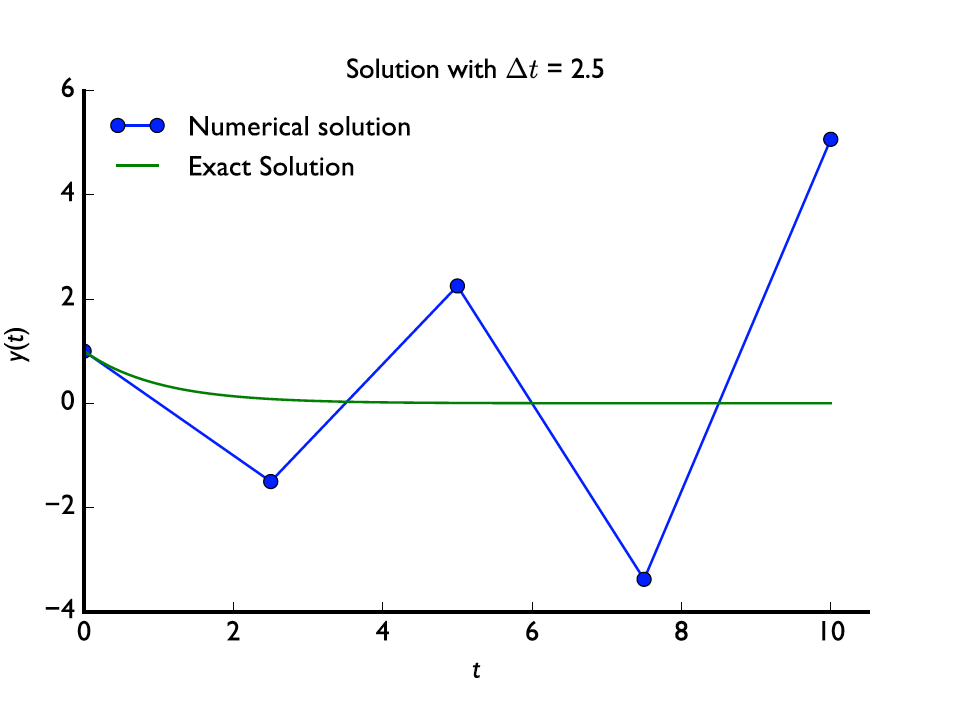

The solution grows over time, even though the true solution decays to 0. This happens
because the magnitude of the solution grows, which makes the right-hand side for the next update larger. This makes the solution grow in magnitude each step.
Stability is an important consideration, and we will talk more about it later.

## Backward Euler

We could use a different method to integrate our original ODE rather than the left-hand
rectangle rule. An obvious alternative is the right-hand rectangle rule:

$$y^{n+1} = y^n + \Delta t f(y^{n+1},t^{n+1}). $$

This method is called the *backward Euler method* or the *implicit Euler method*.

It is implicit because the update is implicitly defined by evaluating $f$ with the value of $y$ we are trying to solve for. That means the update needs to solve the equation

$$y^{n+1} - y^n - \Delta t f(y^{n+1},t^{n+1}) = 0, $$

using a nonlinear solver (unless $f$ is linear in $y$). Therefore, this method is a bit harder to implement in code.

The function below uses the inexact Newton method we defined before to solve the non-linear equation in backward Euler.  

In [3]:
def inexact_newton(f,x0,delta = 1.0e-7, epsilon=1.0e-6, LOUD=False):
    """Find the root of the function f via Newton-Raphson method
    Args:
        f: function to find root of
        x0: initial guess
        delta: finite difference parameter
        epsilon: tolerance
        
    Returns:
        estimate of root
    """
    x = x0
    if (LOUD):
        print("x0 =",x0)
    iterations = 0
    while (np.fabs(f(x)) > epsilon):
        fx = f(x)
        fxdelta = f(x+delta)
        slope = (fxdelta - fx)/delta
        if (LOUD):
            print("x_",iterations+1,"=",x,"-",fx,"/",slope,"=",x - fx/slope)
        x = x - fx/slope
        iterations += 1
    #print("It took",iterations,"iterations")
    return x #return estimate of root

def backward_euler(f,y0,Delta_t,numsteps):
    """Perform numsteps of the backward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        solve_func = lambda u: u-y[n-1] - Delta_t*f(u,t[n])
        y[n] = inexact_newton(solve_func,y[n-1])
    return t, y

Performing the test we did for forward Euler gives the following results:

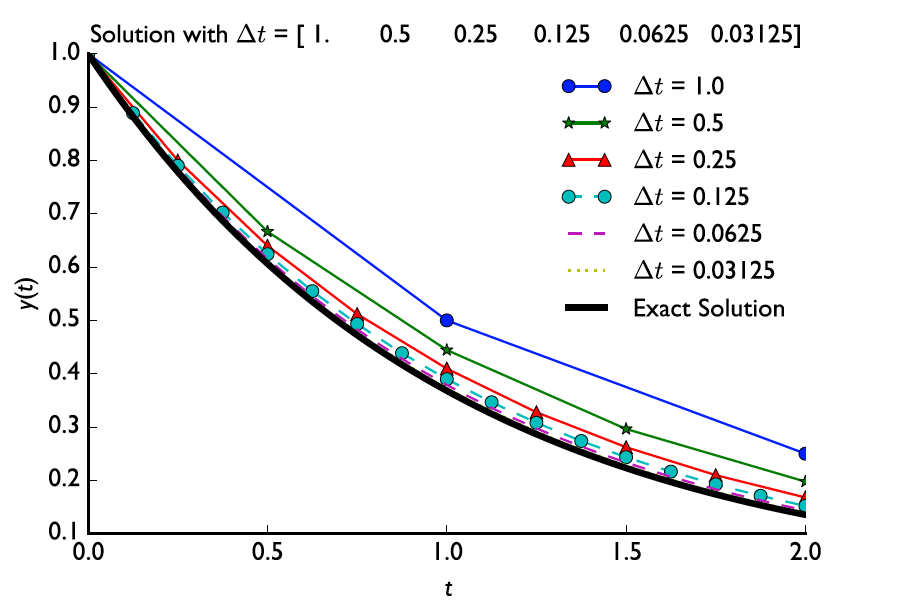

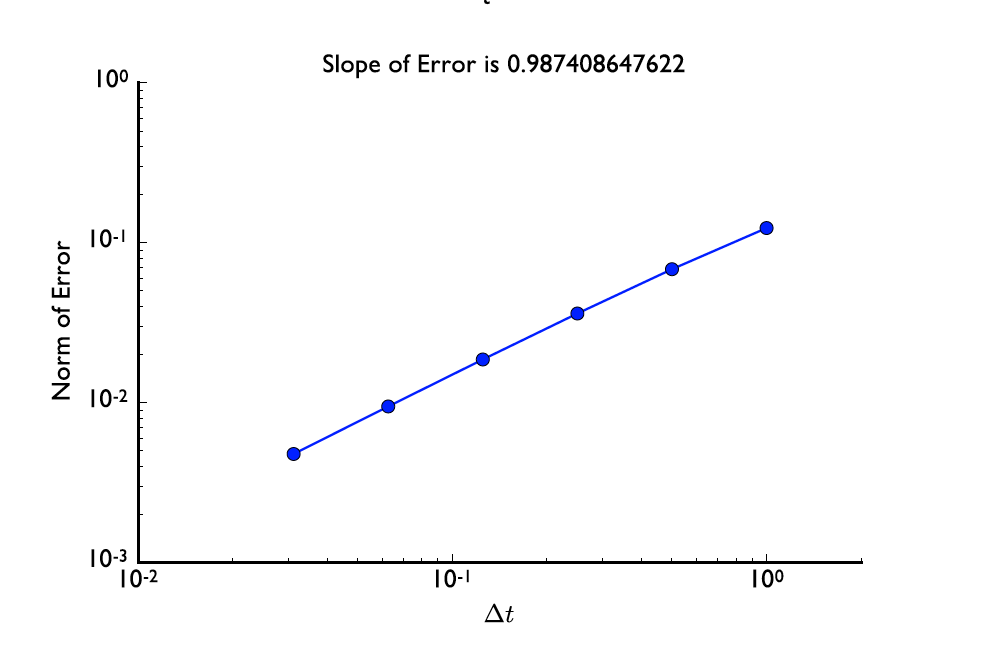

There are several differences between the results from backward Euler and forward Euler. The backward Euler solutions approach the exact solution from above, and the convergence of the error is at the same rate as forward Euler. It seems like we did not get much for the extra effort of solving a nonlinear equation at each step. What we do get is *unconditional stability*. We can see this by using a large time step.

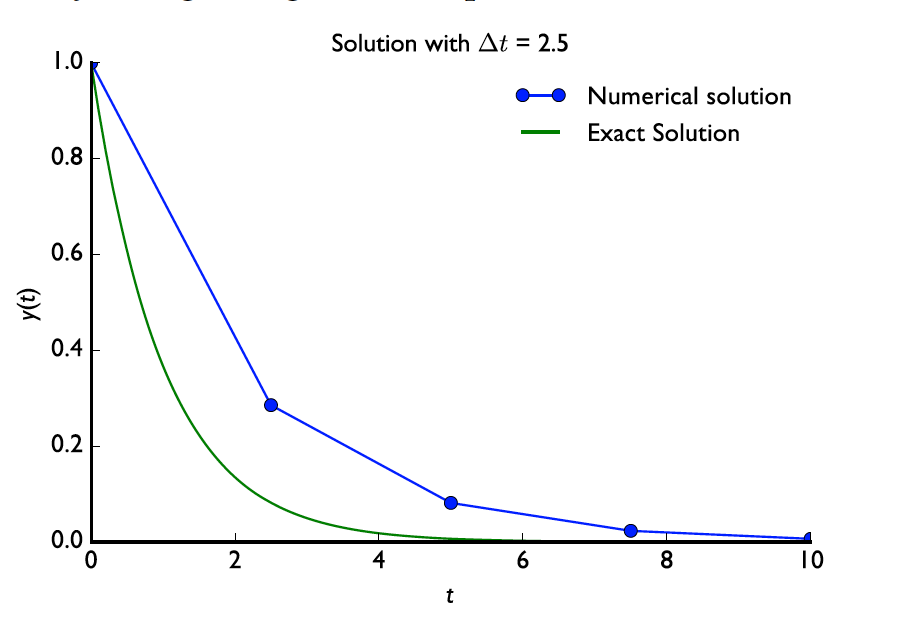

The solution, though not very accurate, still behaves reasonably well. The exact solution decays to 0 as $t \rightarrow \infty$, and the backward Euler solution behaves the same way. This behavior can be very useful on more complicated problems than this simple one.

## Crank-Nicholson (Trapezoid Rule)

We could use the trapezoid rule to integrate the ODE over the time step. Doing this gives:

$$y^{n+1} = y^n + \frac{\Delta t}{2} \left( f(y^{n},t^{n})+ f(y^{n+1},t^{n+1}) \right). $$

This method, often called *Crank–Nicolson*, is also an implicit method because $y^{n+1}$ is on the right-hand side of the equation. For this method the equation we have to solve at each time step is

$$y^{n+1} - y^n - \frac{\Delta t}{2} \left( f(y^{n},t^{n})+ f(y^{n+1},t^{n+1}) \right)=0. $$

Implementing this method is no more difficult than backward Euler. The only change is
the function given to the inexact Newton method.


In [4]:
def crank_nicolson(f,y0,Delta_t,numsteps):
    """Perform numsteps of the Crank--Nicolson method starting at y0
    of the ODE y’(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        solve_func = lambda u:u-y[n-1]-0.5*Delta_t*(f(u,t[n])
                                                    + f(y[n-1],t[n-1]))
        y[n] = inexact_newton(solve_func,y[n-1])
    return t, y

On our test where the solution is $e^{−t}$, we can see the benefit of having a second-order method:

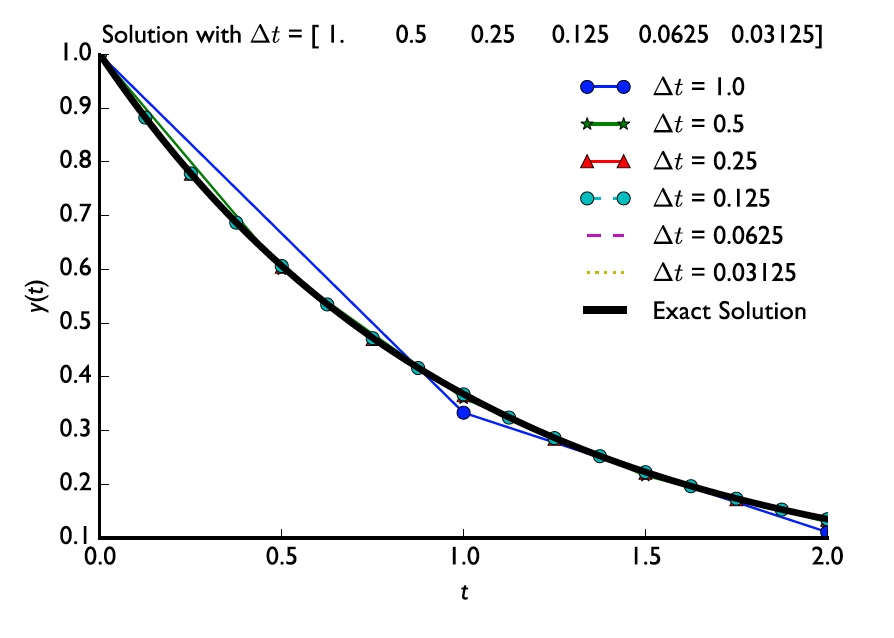

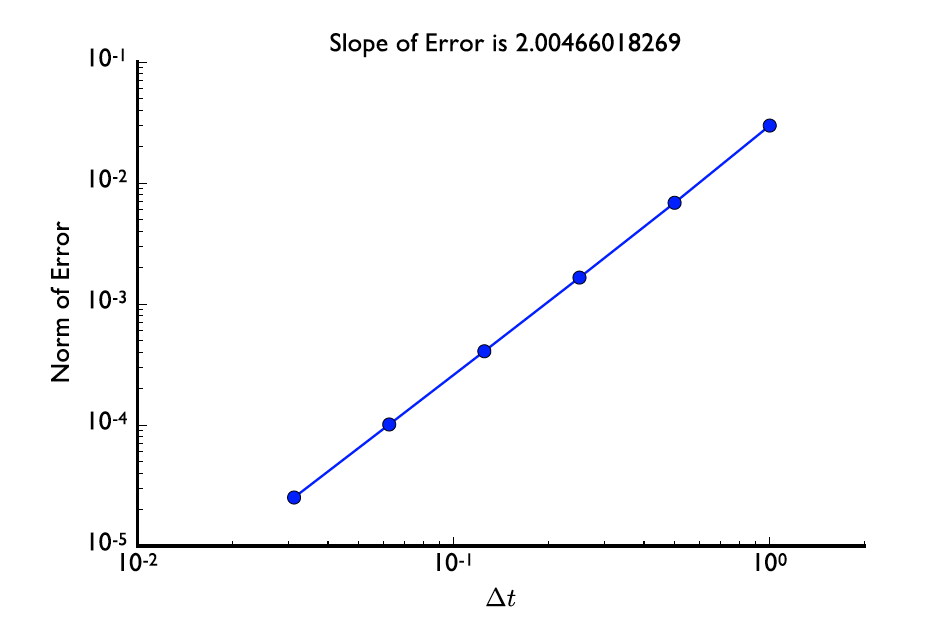

We do get the expected second-order convergence of the error as evidenced by the error
plot. In the comparison of the solutions, except for the large value of 
$\Delta t$, it is hard to distinguish the approximate and the exact solutions.

In terms of stability, Crank–Nicolson is a mixed bag. The method will not diverge as 
$t \rightarrow \infty $, but it can oscillate around the correct solution:

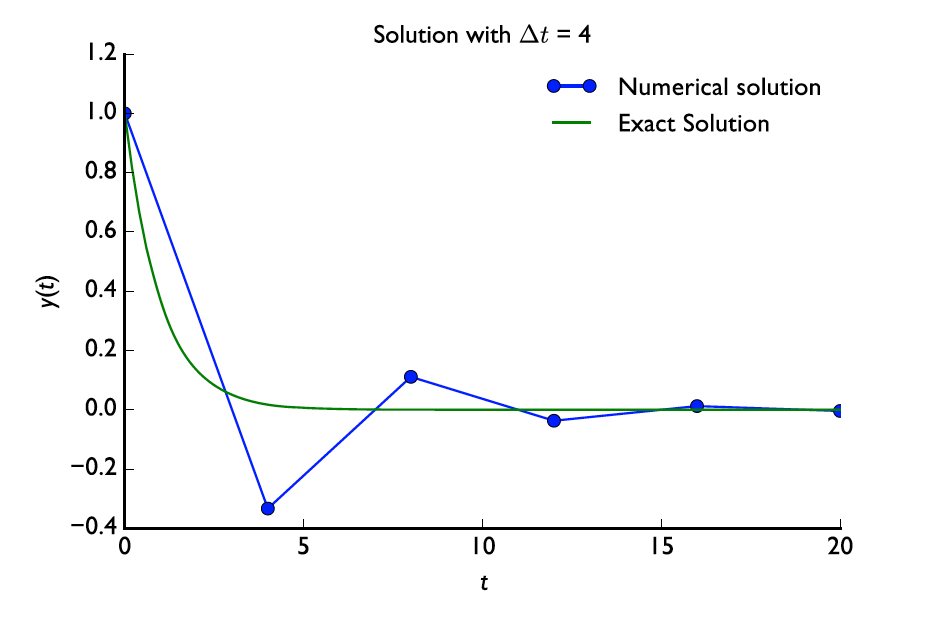

Notice that the oscillation makes the numerical solution negative. This is the case even though the exact solution, $e^{−t}$, cannot be negative.

## Comparison of the Methods

We will compare the methods on a problem that has a driving term as well as decay:

$$ y'(t) = \left( \frac{1}{t+\frac{1}{2}} \right) y(t), \qquad y(0) = \frac{1}{2}.$$

The purpose of this exercise is to show that the issues of accuracy are even more important when the solution is not a simple exponential.

The solution to this problem can be found via the *integrating factor method*:

$$y(t) = \left(t+\frac{1}{2}\right) e^{-t}$$

We will start with a small value of $\Delta t$:

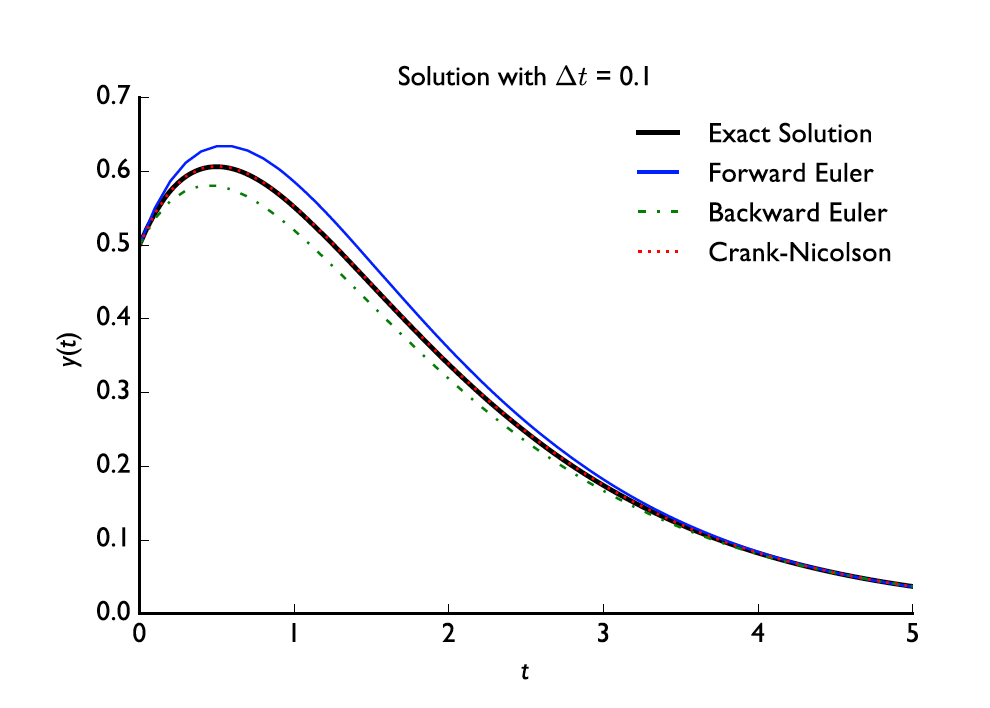

The two Euler methods are equally inaccurate, they just differ in how they are wrong
(above or below). Crank–Nicolson does a good job of following the solution, and is indiscernible from the exact solution.

With a bigger time step we can see the warts of the methods that we have presented:

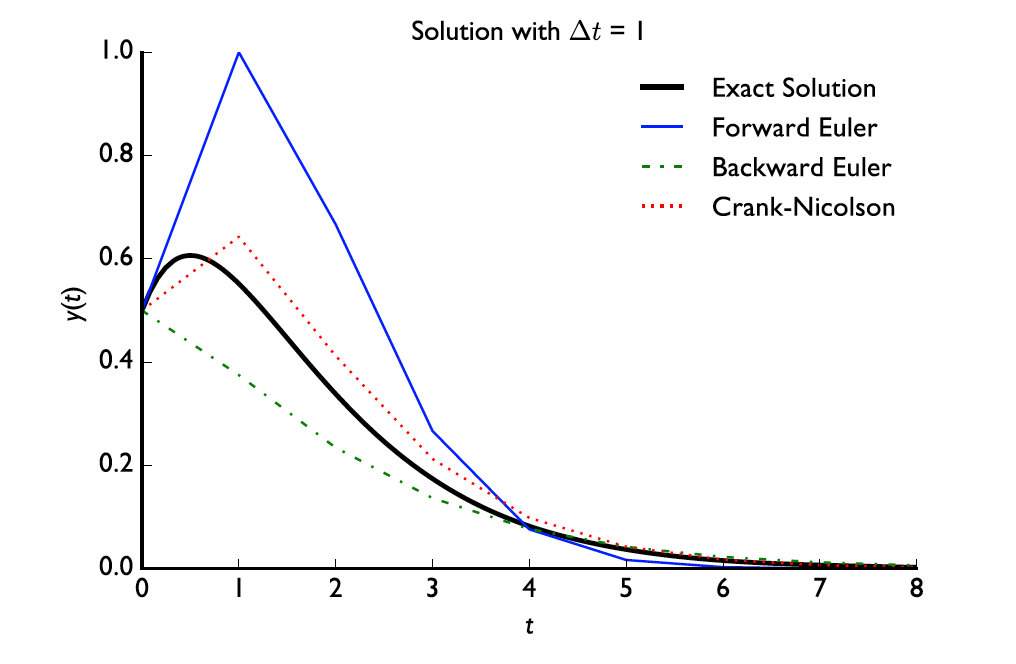

In these results we see that for a large time step, forward Euler completely overshoots the initial growth, backward Euler just starts decaying, and Crank–Nicolson starts off too high before beginning to decay. It appears that even Crank-Nicolson is not accurate enough for this problem with this large step.

## Stability

There is a formal definition of stability for a numerical method for integrating ODEs. To get to this definition, consider the ODE

$$ y'(t) = \alpha y(t).$$

For any single step method we can write:

$$y^{n+1} = g y^n$$

A solution method is said to be stable if $|g| \le 1.$ Furthermore, a solution is said to be nonoscillatory if $0 \le g \le 1.$ The quantity $g$ is often called the *growth rate*.

We first look at forward Euler on this ODE:

$$y^{n+1} = y^n - \alpha \Delta t y^n = \left(1-\alpha \Delta t \right) y^n, $$

which implies that the growth rate for forward Euler is:

$$ g_{FE} = 1-\alpha \Delta t.$$

To make sure that $|g| \le 1$ we need to have $\alpha \Delta t \le 2$. To be non-oscillatory we need $\alpha \Delta t \le 1$.

This is why when we solved

$$ y'(t) = -y(t) $$

with $\Delta t = 2.5$, the solution grew in an unstable manner. Because there is a restriction on the time step for stability, we call the forward Euler method *conditionally stable*.

The value of the growth rate for backward Euler can be easily derived. We start with

$$ y^{n+1} = y^n - \alpha \Delta t y^n+1$$

which when rearranged is

$$ y^{n+1} = \frac{1}{1+ \alpha \Delta t} y^n $$

This makes 

$$ g_{BE} = \frac{1}{1+ \alpha \Delta t}.$$

For any $t > 0$, $g$ will be between 0 and 1. Therefore, backward Euler is unconditionally stable and unconditionally non-oscillatory.

The Crank–Nicolson method has

$$g_{CN} = \frac{2-\alpha \Delta t}{2+ \alpha \Delta t}.$$

This method will be unconditionally stable because
$ \lim\limits_{t \rightarrow \infty} g_{CN} = −1.$ It is conditionally non-oscillatory because $g_{CN} < 0$ for $\alpha \Delta t> 2.$ In the original example, we had $\alpha \Delta t = 4$, and we saw noticeable oscillations.

In the contrast between the implicit methods, Crank–Nicolson and backward Euler, we
see a common theme in numerical methods: to get better accuracy one often has to sacrifice robustness. In this case Crank–Nicolson allows oscillations in the solution, but its error decreases at second-order in the time step size. Backward Euler is non-oscillatory, but the error converges more slowly than Crank–Nicolson.

## Fourth-Order Runge-Kutta Method

There is one more method that we need to consider at this point. It is an explicit method
called a Runge–Kutta method. The particular one we will learn is fourth-order accurate in $\Delta t$. That means that if we decrease $\Delta t$ by a factor of 2, the error will decrease by a factor of
$2^4$ = 16. The method can be written as:

$$ y^{n+1} = y^{n} + \frac{1}{6} \left(\Delta y_1 + 2 \Delta y_2 + 2 \Delta y_3 + \Delta y_4 \right) ,$$

where

$$ \Delta y_1 = \Delta t f(y^n,t^n), $$

$$ \Delta y_2 = \Delta t f(y^n + \frac{\Delta y_1}{2}, t^n + \frac{\Delta t}{2} ), $$

$$ \Delta y_3 = \Delta t f(y^n + \frac{\Delta y_2}{2}, t^n + \frac{\Delta t}{2} ), $$

$$ \Delta y_4 = \Delta t f(y^n + \Delta y_3 ,t^n + \Delta t). $$

To get fourth-order accuracy, this method takes a different approach to integrating the righthand
side of the ODE. Basically, it makes several projections forward and combines them in
such a way that the errors cancel to make the method fourth-order.
Implementing this method is not difficult either.

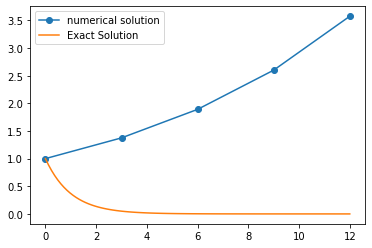

In [5]:
def RK4(f,y0,Delta_t,numsteps):
    """Perform numsteps of the 4th order Runge-Kutta method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    y = np.zeros(numsteps+1)
    t = np.arange(numsteps+1)*Delta_t
    y[0] = y0
    for n in range(1,numsteps+1):
        dy1 = Delta_t * f(y[n-1], t[n-1])
        dy2 = Delta_t * f(y[n-1] + 0.5*dy1, t[n-1] + 0.5*Delta_t)
        dy3 = Delta_t * f(y[n-1] + 0.5*dy2, t[n-1] + 0.5*Delta_t)
        dy4 = Delta_t * f(y[n-1] + dy3, t[n-1] + Delta_t)
        y[n] = y[n-1] + 1.0/6.0*(dy1 + 2.0*dy2 + 2.0*dy3 + dy4)
    return t, y

import numpy as np
import matplotlib.pyplot as plt
RHS = lambda y,t: -y
Delta_t = 3.0
t_final = 12.0
t,y = RK4(RHS,1,Delta_t,t_final/Delta_t)
plt.plot(t,y,'o-',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.exp(-t_fine),label="Exact Solution")
plt.legend()

We will first try this Runge–Kutta method on the problem with growth and decay given in
Eq. (17.6) with a large time step.

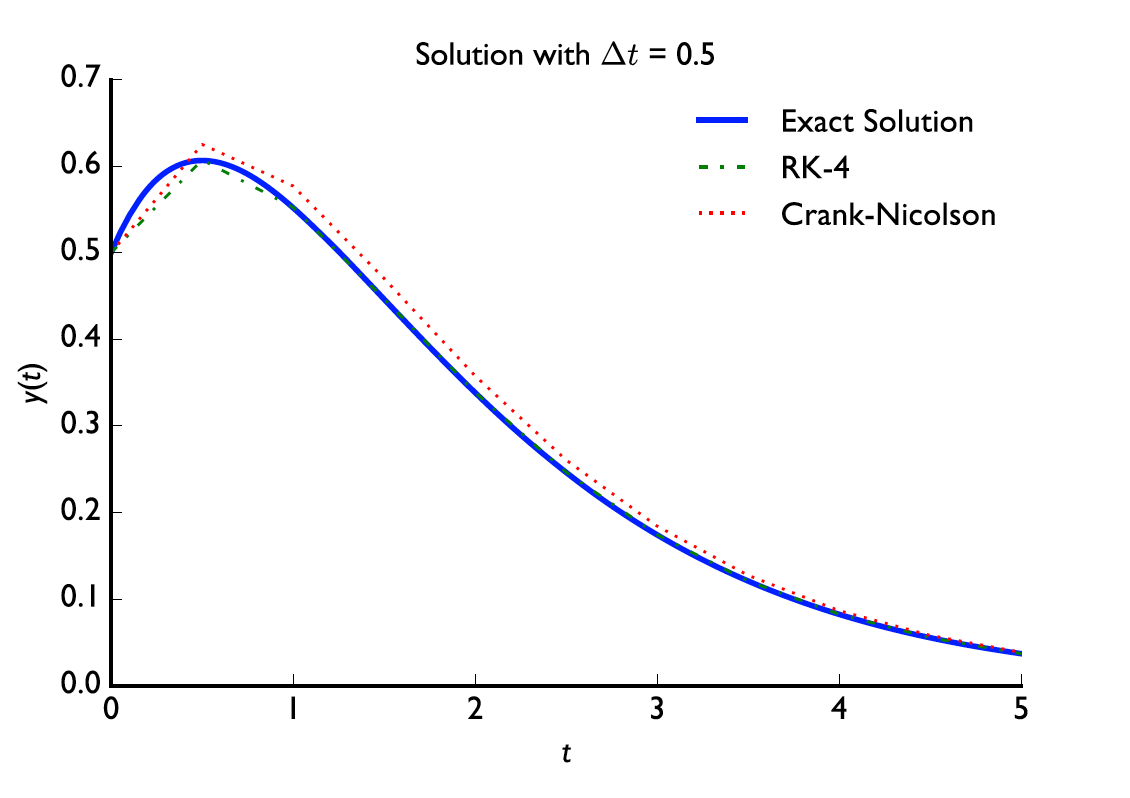

It seems to do better that Crank–Nicolson with a large time step, but since it is an explicit
method, there are limits: with a large enough time step the solution will oscillate and can be
unstable.

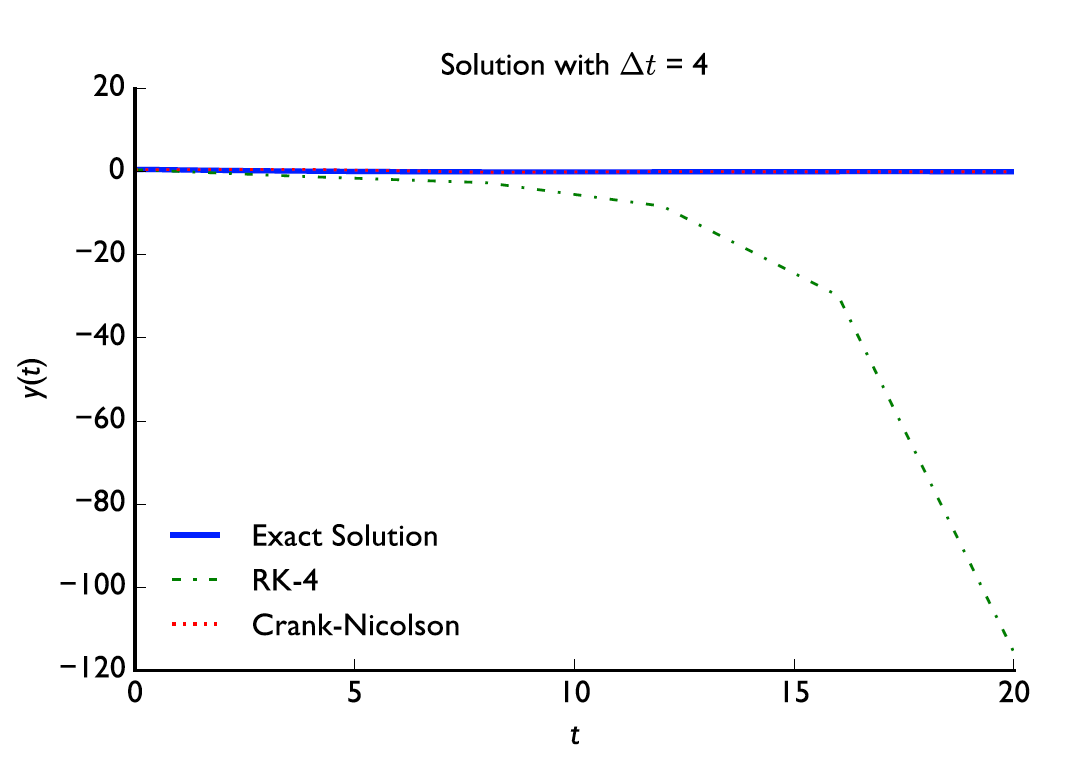

Therefore, we need to be careful when we use the RK-4 method that the time step is not
too large.

### Stability for RK4

For the fourth-order Runge–Kutta method presented above, we can look at the stability
by examining how it performs on the problem $y'(t)=−αy.$ On this problem the intermediate
values are

$$ \Delta y_1 = -\alpha \Delta t y^n, $$

$$ \Delta y_2 = -\alpha \Delta t \left( y^n + \frac{\Delta y_1}{2} \right), $$

$$= = -\alpha \Delta t \left(1- \frac{\alpha \Delta t}{2} \right) y^n, $$

$$ \Delta y_3 = -\alpha \Delta t \left( y^n + \frac{\Delta y_2}{2} \right), $$

$$= = -\alpha \Delta t \left(1- \frac{\alpha \Delta t}{2} \left(1- \frac{\alpha \Delta t}{2} \right)  \right) y^n, $$

$$ \Delta y_4 = -\alpha \Delta t \left( y^n + \Delta y_3 \right), $$

$$= -\alpha \Delta t \left( 1- \alpha \Delta t \left( 1- \frac{\alpha \Delta t}{2} \left(1- \frac{\alpha \Delta t}{2} \right) \right) \right) y^n, $$

Using these results in the update for $y^{n+1}$ gives

$$ y^{n+1} = \left(\frac{\alpha^4 \Delta t^4}{24} - \frac{\alpha^3 \Delta t^3}{6} + \frac{\alpha^2 \Delta t^2}{2} - \alpha \Delta t + 1 \right) y^n $$

This implies that the growth rate for RK4 is

$$ g_{RK4} = \frac{\alpha^4 \Delta t^4}{24} - \frac{\alpha^3 \Delta t^3}{6} + \frac{\alpha^2 \Delta t^2}{2} - \alpha \Delta t + 1 .$$

This is a fourth-degree polynomial in $\alpha \Delta t$. For $\alpha \Delta t > 0$ the value of $g_{RK4}$ is positive. Additionally, the stability limit is

$$\alpha \Delta t \le \approx 2.78529356. $$

This implies that RK4 is conditionally stable, and is non-oscillatory where it is stable. The stability
criterion is less restrictive for RK4 than for forward Euler, and where Crank–Nicolson
is non-oscillatory, RK4 will be as well.

## Systems of Differential Equations

Often we will be concerned with solving a system of ODEs rather than a single ODE.
The explicit methods translate to this scenario directly. However, we will restrict ourselves to
systems that can be written in the form:

$$ \textbf{y}'(t) = \textbf{A}(t) \textbf{y} + \textbf{c}(t), \qquad \textbf{y}(0) = \textbf{y}_0.$$

In this equation $\textbf{A}(t)$ is a matrix that can change over time, and $\textbf{c}(t)$ is a function of t only. For systems of this type our methods are written as follows:

 - Forward Euler
 
 $$ \textbf{y}^{n+1} = \textbf{y}^{n} + \Delta t \textbf{A}(t^n) \textbf{y}^n + \Delta t \textbf{c}(t^n).$$

 - Backward Euler

 $$ \textbf{y}^{n+1} = \textbf{y}^{n} + \Delta t \textbf{A}(t^{n+1}) \textbf{y}^{n+1} + \Delta t \textbf{c}(t^{n+1}).$$

which rearranges to

$$\left( \textbf{I} - \Delta t \textbf{A}(t^{n+1}) \right) \textbf{y}^{n+1} = \textbf{y}^{n} + \Delta t \textbf{c}(t^{n+1}).$$

Therefore, for backward Euler we will have to solve a linear system of equations at each
time step.

 - Crank Nicholson
 
$$\left( \textbf{I} - \frac{\Delta t}{2} \textbf{A}(t^{n+1}) \right) \textbf{y}^{n+1} = \left( \textbf{I} + \frac{\Delta t}{2} \textbf{A}(t^{n}) \right) \textbf{y}^{n} + \frac{\Delta t}{2} \left( \textbf{c}(t^{n+1}) + \textbf{c}(t^{n}) \right) .$$
 
 This will also involve a linear solve at each step.
 
 - Fourth-order Runge-Kutta
 
$$ \textbf{y}^{n+1} = \textbf{y}^{n} + \frac{1}{6} \left( \Delta \textbf{y}_1 + 2  \Delta \textbf{y}_2 + 2  \Delta \textbf{y}_3 +   \Delta \textbf{y}_4 \right),$$

$$ \Delta \textbf{y}_1 = \Delta t \textbf{A}(t^{n}) \textbf{y}^{n} + \Delta t \textbf{c}(t^{n}) $$

$$ \Delta \textbf{y}_2 = \Delta t \textbf{A}(t^{n}+\frac{\Delta t}{2}) \left( \textbf{y}^{n}+ \frac{\Delta \textbf{y}_1}{2} \right)+  \Delta t \textbf{c}(t^{n}+\frac{\Delta t}{2}) $$

$$ \Delta \textbf{y}_3 = \Delta t \textbf{A}(t^{n}+\frac{\Delta t}{2}) \left( \textbf{y}^{n} + \frac{\Delta \textbf{y}_2}{2} \right) + \Delta t \textbf{c}(t^{n}+\frac{\Delta t}{2}) $$

$$ \Delta \textbf{y}_4 = \Delta t \textbf{A}(t^{n}+\Delta t) \left(\textbf{y}^{n} + \Delta \textbf{y}_3 \right) + \Delta t \textbf{c}(t^{n}+ \Delta t) $$

 
 
As noted above, the implicit methods require the solution of a linear system at each time step,
while the explicit methods do not.

We first define a function for solving forward Euler on a system.
 


In [6]:
def forward_euler_system(Afunc,c,y0,Delta_t,numsteps):
    """Perform numsteps of the forward euler method starting at y0
    of the ODE y'(t) = A(t) y(t) + c(t)
    Args:
        Afunc: function to compute A matrix
        c: nonlinear function of time
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    unknowns = y0.size
    y = np.zeros((unknowns,numsteps+1))
    t = np.arange(numsteps+1)*Delta_t
    y[0:unknowns,0] = y0
    for n in range(1,numsteps+1):
        yold = y[0:unknowns,n-1]
        A = Afunc(t[n-1])
        y[0:unknowns,n] = yold + Delta_t * (np.dot(A,yold) + c(t[n-1]))
    return t, y

As a test we will solve the ODE:

$y''(t) = −y(t), \qquad y(0) = 1, y'(0) = 0.$$

At first blush this does not seem compatible with our method for solving a system of equations.

Moreover, we have not covered how to solve ODEs with derivatives other than first
derivatives. Nevertheless, we can write this as a system using the definition:

$$u(t) = y'(t),$$

to get

$$ \frac{d}{dt} \begin{pmatrix}
u \\
y
\end{pmatrix} = \begin{pmatrix}
0 & -1 \\
1 & 0 
\end{pmatrix}
\begin{pmatrix}
u \\
y
\end{pmatrix} $$

We will set this up in Python and solve it with Forward Euler.  The solution is $y(t) = \cos{(t)}$.

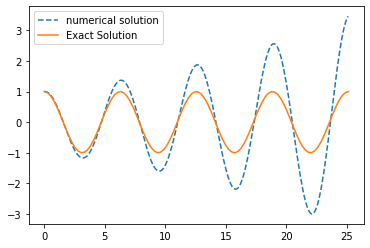

In [7]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.1
t_final = 8*np.pi
t,y = forward_euler_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

The error grows over time. What’s happening here is that the numerical error builds over
time and this causes the magnitude to grow over time. Using a smaller value of 
$\Delta t$ can help, but not completely remove the problem.


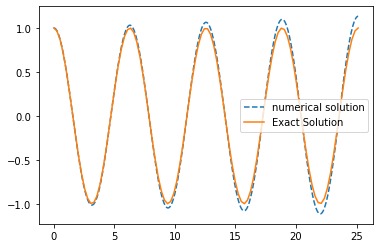

In [8]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.01
t_final = 8*np.pi
t,y = forward_euler_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

We have really just delayed the inevitable: the growth of the magnitude of the solution is
increasing.

To understand what is going on we will look a phase field plot for this ODE. The phase
field plot for this system tells us the direction of the derivatives of $y$ and $u$ given a value for
each. Using the phase field and a starting point, we can follow the arrows to see how the true
solution behaves. In the following phase figure, the solid black line shows the behavior of the
solution when $y(0) = 1$ and $u(t) = y'(0) = 0$. The solution starts at the solid circle and goes
around twice in the time plotted ($t = 0$ to $4\pi$).

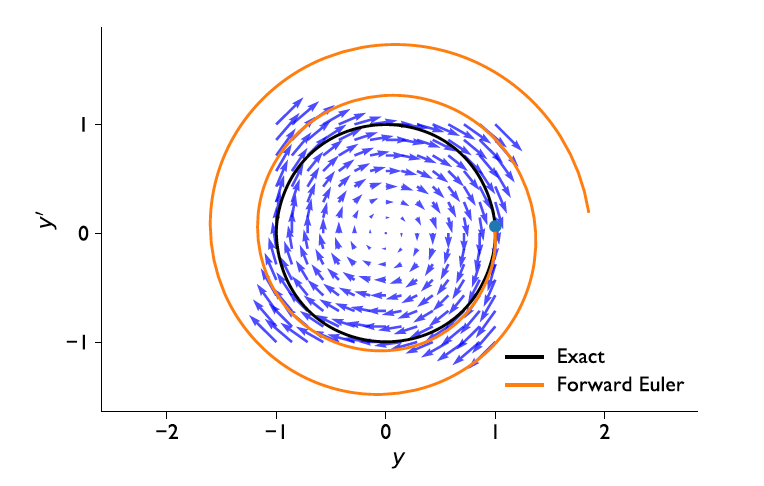

The solution looks like a circle in the phase field because of the repeating periodic nature
of the solution. However, the forward Euler solution has errors that grow over time, so that
each time around, the circle grows larger.

The backward Euler method is implemented next. To solve the linear system we will use a
Gaussian elimination function that we defined previously.

In [9]:
def swap_rows(A, a, b):
    """Rows two rows in a matrix, switch row a with row b
    
    args:
        A: matrix to perform row swaps on
        a: row index of matrix
        b: row index of matrix
        
    returns: nothing
    
    side effects:
    changes A to rows a and b swapped
    """
    assert (a>=0) and (b>=0)
    N = A.shape[0] #number of rows
    assert (a<N) and (b<N) #less than because 0-based indexing
    temp = A[a,:].copy()
    A[a,:] = A[b,:].copy()
    A[b,:] = temp.copy()
def BackSub(aug_matrix,x):
    """back substitute a N by N system after Gaussian elimination
    
    Args:
        aug_matrix: augmented matrix with zeros below the diagonal
        x: length N vector to hold solution
    Returns:
        nothing
    Side Effect:
    x now contains solution
    """
    N = x.size
    for row in range(N-1,-1,-1):
        RHS = aug_matrix[row,N]
        for column in range(row+1,N):
            RHS -= x[column]*aug_matrix[row,column]
        x[row] = RHS/aug_matrix[row,row]
    return
def GaussElimPivotSolve(A,b,LOUD=0):
    """create a Gaussian elimination with pivoting matrix for a system
    
    Args:
        A: N by N array
        b: array of length N
    Returns:
        solution vector in the original order
    """
    [Nrow, Ncol] = A.shape
    assert Nrow == Ncol
    N = Nrow
    #create augmented matrix
    aug_matrix = np.zeros((N,N+1))
    aug_matrix[0:N,0:N] = A
    aug_matrix[:,N] = b
    #augmented matrix is created
    
    #create scale factors
    s = np.zeros(N)
    count = 0
    for row in aug_matrix[:,0:N]: #don't include b
        s[count] = np.max(np.fabs(row))
        count += 1
    if LOUD:
        print("s =",s)
    if LOUD:
        print("Original Augmented Matrix is\n",aug_matrix)
    #perform elimination
    for column in range(0,N):
        
        #swap rows if needed
        largest_pos = np.argmax(np.fabs(aug_matrix[column:N,column]/s[column])) + column
        if (largest_pos != column):
            if (LOUD):
                print("Swapping row",column,"with row",largest_pos)
                print("Pre swap\n",aug_matrix)
            swap_rows(aug_matrix,column,largest_pos)
            #re-order s
            tmp = s[column]
            s[column] = s[largest_pos]
            s[largest_pos] = tmp
            if (LOUD):
                print("A =\n",aug_matrix)
        #finish off the row
        for row in range(column+1,N):
            mod_row = aug_matrix[row,:]
            mod_row = mod_row - mod_row[column]/aug_matrix[column,column]*aug_matrix[column,:]
            aug_matrix[row] = mod_row
    #now back solve
    x = b.copy()
    if LOUD:
        print("Final aug_matrix is\n",aug_matrix)
    BackSub(aug_matrix,x)
    return x

def backward_euler_system(Afunc,c,y0,Delta_t,numsteps):
    """Perform numsteps of the forward euler method starting at y0
    of the ODE y'(t) = A(t) y(t) + c(t)
    Args:
        Afunc: function to compute A matrix
        c: nonlinear function of time
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    unknowns = y0.size
    y = np.zeros((unknowns,numsteps+1))
    t = np.arange(numsteps+1)*Delta_t
    y[0:unknowns,0] = y0
    for n in range(1,numsteps+1):
        yold = y[0:unknowns,n-1]
        A = Afunc(t[n])
        LHS = np.identity(unknowns) - Delta_t * A
        RHS = yold + c(t[n])*Delta_t
        y[0:unknowns,n] = GaussElimPivotSolve(LHS,RHS)
    return t, y

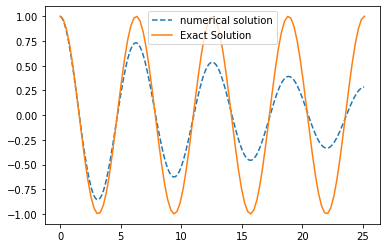

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.1
t_final = 8*np.pi
t,y = backward_euler_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

Results with 
t = 0.1 show that error builds over time, but in a different way than forward
Euler.

Now the numerical error builds over time, but the error causes the solution to damp out
over time. As before, decreasing  $\Delta t$ only delays the onset of the error.
The phase field plot shows that instead of the path growing, backward Euler’s path spirals
down to zero.

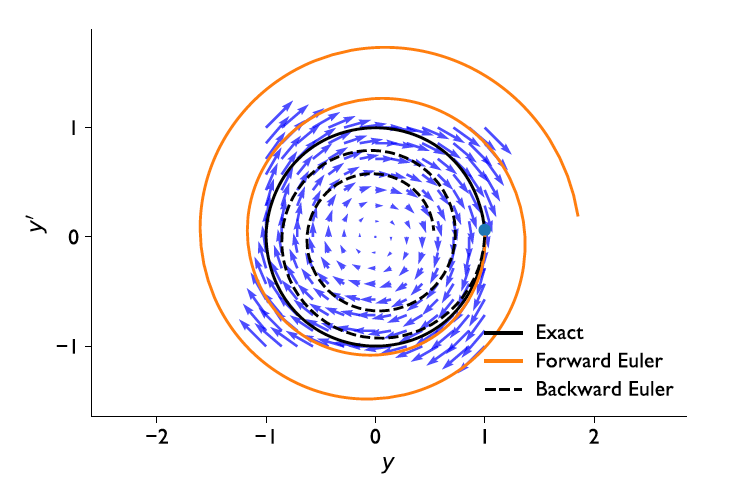

Larger time steps make the solution decay to zero faster. If we take a small time step, the
decay is slower but still occurs.

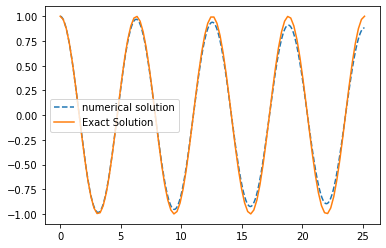

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.01
t_final = 8*np.pi
t,y = backward_euler_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

The takeaway here is that first-order accurate methods have errors that build over time.
Forward Euler - the errors cause the solution to grow, whereas, Backward Euler has the solution
damp to zero over time.

### Stability for Systems of ODEs

For a system of initial value problems, the stability condition is derived by looking at the
problem

$$ \textbf{y}' =−\textbf{A}\textbf{y}$$ 

If we multiply both sides of the equation by a left-eigenvector of $\textbf{A}$, $\textbf{l}_k$ with associated eigenvalue $\alpha_k$ we get

$$ \textbf{u}'_k =−\alpha_k \textbf{u}_k, $$

where $\textbf{u}_k = \textbf{l}_k \cdot \textbf{y}.$

Notice that each row of this equation is identical to the model equation we had for stability
for single initial value problems. Therefore, we can replace the $\alpha$ in our equations
for the growth rate $g$ by the eigenvalues of the matrix $\textbf{A}$. Then we can determine under what
conditions $|g| \le 1$ to find a range of stability.

In the example above where

$$ \textbf{A} = \begin{pmatrix}
0 & -1 \\
1 & 0 
\end{pmatrix}, $$

the eigenvalues are $\pm i$.  Using the growth rate for forward Euler, we get $g_{FE} = 1 \pm i \Delta t$, which implies

$$ |g_{FE}| = \sqrt{1+ \Delta t^2}.$$

This result means that for any $\Delta t$, forward Euler will not be stable because any positive 
$\Delta t$ makes $|g_{FE}| > 1$. This is what we saw in the example. Backward Euler, however, is stable
because

$$ |g_{BE}| = \frac{1}{\sqrt{1+ \Delta t^2}},$$

which is less than one for any positive $\Delta t$.

### Crank-Nicholson for Systems

Now we will look at Crank–Nicolson to see how it behaves. A Python implementation of
Crank–Nicolson is given next:


In [12]:
def cn_system(Afunc,c,y0,Delta_t,numsteps):
    """Perform numsteps of the forward euler method starting at y0
    of the ODE y'(t) = A(t) y(t) + c(t)
    Args:
        Afunc: function to compute A matrix
        c: nonlinear function of time
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    unknowns = y0.size
    y = np.zeros((unknowns,numsteps+1))
    t = np.arange(numsteps+1)*Delta_t
    y[0:unknowns,0] = y0
    for n in range(1,numsteps+1):
        yold = y[0:unknowns,n-1]
        A = Afunc(t[n])
        LHS = np.identity(unknowns) - 0.5*Delta_t * A
        A = Afunc(t[n-1])
        RHS = yold + 0.5*Delta_t * np.dot(A,yold) + 0.5*(c(t[n-1]) + c(t[n]))*Delta_t
        y[0:unknowns,n] = GaussElimPivotSolve(LHS,RHS)
    return t, y

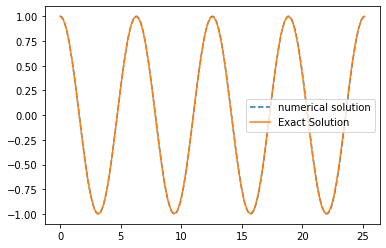

In [13]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.1
t_final = 8*np.pi
t,y = cn_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

The error build up is not nearly as large of a problem. Even if we look at the solution over
a much longer time, the error is not significant:

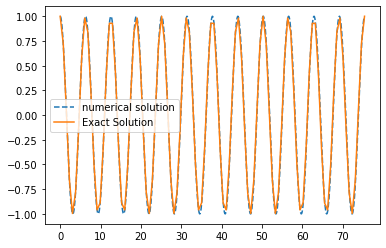

In [14]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.1
t_final = 24*np.pi
t,y = cn_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

The phase field plot demonstrates that the accuracy of Crank-Nicolson allows it to not
have any strange behavior in the phase field. The numerical solution appears as a circle in the
phase field:

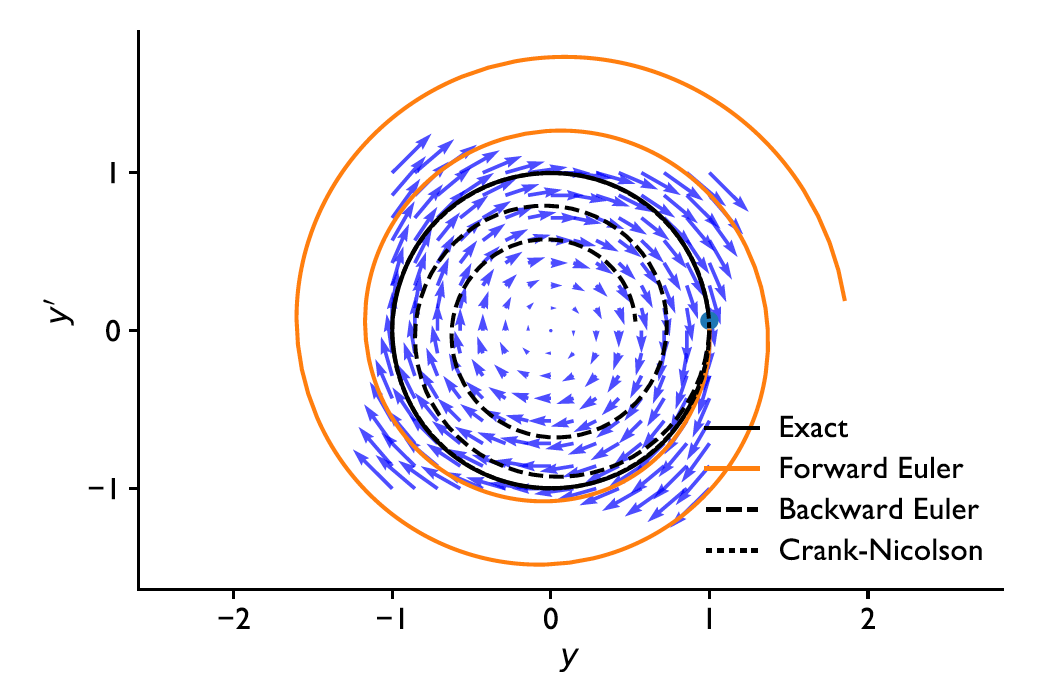

One can show that for this problem, Crank–Nicolson is unconditionally stable because $|gCN| = 1$ for any 
$\Delta t$. This also explains why the solution did not damp or grow over time.

### RK4 for Systems

Finally, we generalize our implementation of fourth-order Runge–Kutta to handle systems
of equations.

In [15]:
def RK4_system(Afunc,c,y0,Delta_t,numsteps):
    """Perform numsteps of the forward euler method starting at y0
    of the ODE y'(t) = f(y,t)
    Args:
        f: function to integrate takes arguments y,t
        y0: initial condition
        Delta_t: time step size
        numsteps: number of time steps
        
    Returns:
        a numpy array of the times and a numpy
        array of the solution at those times
    """
    numsteps = int(numsteps)
    unknowns = y0.size
    y = np.zeros((unknowns,numsteps+1))
    t = np.arange(numsteps+1)*Delta_t
    y[0:unknowns,0] = y0
    for n in range(1,numsteps+1):
        yold = y[0:unknowns,n-1]
        A = Afunc(t[n-1])
        dy1 = Delta_t * (np.dot(A,yold) + c(t[n-1])) 
        A = Afunc(t[n-1] + 0.5*Delta_t)
        dy2 = Delta_t * (np.dot(A,y[0:unknowns,n-1] + 0.5*dy1) 
                         + c(t[n-1] + 0.5*Delta_t))
        dy3 = Delta_t * (np.dot(A,y[0:unknowns,n-1] + 0.5*dy2) 
                         + c(t[n-1] + 0.5*Delta_t))
        A = Afunc(t[n] + Delta_t)
        dy4 = Delta_t * (np.dot(A,y[0:unknowns,n-1] + dy3) + c(t[n]))
        y[0:unknowns,n] = y[0:unknowns,n-1] + 1.0/6.0*(dy1 + 2.0*dy2 + 2.0*dy3 + dy4)
    return t, y

Like Crank–Nicolson, RK4 does not display noticeable error on our test problem.

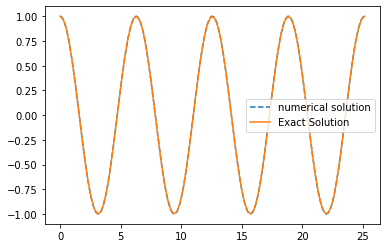

In [16]:
import numpy as np
import matplotlib.pyplot as plt
#Set up A
Afunc = lambda t: np.array([(0,-1),(1,0)])
#set up c
c = lambda t: np.zeros(2)
#set up y
y0 = np.array([0,1])
Delta_t = 0.1
t_final = 8*np.pi
t,y = RK4_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[1],'--',label="numerical solution")
t_fine = np.linspace(0,t_final,100)
plt.plot(t_fine,np.cos(t_fine),label="Exact Solution")
plt.legend()

On this simple problem, RK4 appears to be as good as Crank-Nicolson. The stability limit
for RK4 can be derived by replacing $\alpha$ with $\pm i$ in the equation for the single ODE stability criterion. The result is that $\Delta t < 2.78529356$ will give a stable, if inaccurate, solution.

# Point Reactor Kinetics Equations

The simplest model to describe the behavior of the power in a nuclear reactor are the point-reactor kinetics equations (PRKEs) with one delayed neutron precursor group. This is an important model for the time-dependent behavior of nuclear reactors, and other nuclear systems. [See the further reading section in McClarren in this chapter for suggestions on background references for this model.]

The PRKEs are a system of two ODEs:

$$ p'(t) = \frac{\rho-\beta}{\Lambda} p(t) + \lambda C(t), $$

$$ C'(t) = \frac{\beta}{\Lambda} p(t) - \lambda C(t). $$

Here $p$ is the number of free neutrons in the reactor, $\rho$ is the reactivity

$$ \rho = \frac{k-1}{k}, $$

for $k$ the effective multiplication factor, $\beta$ is the fraction of neutrons produced by fission that
are delayed, $\Lambda$ is the mean time between neutron generations in the reactor, $\lambda$ is the number of delayed neutrons produced per unit time, and $C$ is the number of delayed neutron precursors (nuclides that will emit a neutron).

In our notation

$$\textbf{y} = (p(t), C(t))^T, $$

$$ \textbf{A}(t) = \begin{pmatrix}
\frac{\rho-\beta}{\Lambda} & \lambda \\
\frac{\beta}{\Lambda} & -\lambda 
\end{pmatrix}, $$

and

$$\textbf{c}(t) = \textbf{0}.$$

Recall that at steady-state, (i.e. $p'(t) = C'(t) = 0$), to have a non-trivial solution $\rho = 0$, i.e.,
the solution is critical. In this case, the solution to this system is

$$p=\frac{\lambda \Lambda}{\beta}.$$

We will need to know this for some of our test cases.

Also, some typical values for the constants are $\beta = 750 \times 10^{−5}$, $\Lambda = 2 \times 10^{−5}$ sec, $\lambda = 10^{−1}$ sec$^{-1}$.

### Rod-Drop

Now we simulate the situation where we have a large amount of negative reactivity (a dollar \\$ ) is a reactivity unit, where one dollar of reactivity is equal to the value of $\beta$ for the
system) inserted into a critical reactor, $\rho =−2$ \\$ =−2$\beta$. This is the scenario that occurs when
a control rod is rapidly inserted into the reactor. The tricky part here is setting up the function for
$\textbf{A}$(t).  We will start with RK4.

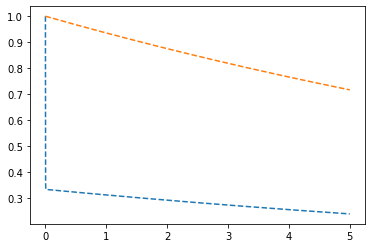

In [17]:
#Set up A
beta = 705.0e-5
Lambda = 2.0e-5 #s
l = 1.0e-1 #s**-1
rho = -2.0*beta
Afunc = lambda t: np.array([((rho-beta)/Lambda,l),
                            (beta/Lambda,-l)])
#set up c
c = lambda t: np.zeros(2)
#set up inital vector
y0 = np.array([1,beta/(l*Lambda)])
Delta_t = 0.001 #1 millisecond
t_final = 5
t,y = RK4_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[0]/y0[0],'--',label="Power")
plt.plot(t,y[1]/y0[1],'--',label="Precursors")

We look at the results on a semilog scale so we can see the prompt jump: the rapid decrease
in the neutron population after the control rod is inserted.

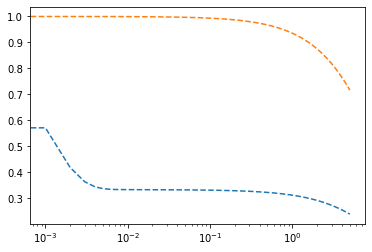

In [18]:
#Set up A
beta = 705.0e-5
Lambda = 2.0e-5 #s
l = 1.0e-1 #s**-1
rho = -2.0*beta
Afunc = lambda t: np.array([((rho-beta)/Lambda,l),
                            (beta/Lambda,-l)])
#set up c
c = lambda t: np.zeros(2)
#set up inital vector
y0 = np.array([1,beta/(l*Lambda)])
Delta_t = 0.001 #1 millisecond
t_final = 5
t,y = RK4_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[0]/y0[0],'--',label="Power")
plt.plot(t,y[1]/y0[1],'--',label="Precursors")
plt.xscale('log')

Notice that our time step is smaller than the prompt jump (as can be seen on the semilog
scale). With a larger time step, RK4 has problems. In fact with a time step of 
$\Delta t = 0.01$ sec, the power is $10^{303}$ at 12 sec. It seems that this time step is beyond the stability limit for RK4. This can be checked by evaluating the eigenvalues of the $\textbf{A}$ matrix for this problem and using the formula for $g_{RK4}$. The stability limit is $\Delta t \le 0.00247574$ sec.

Using backward Euler, we can take this larger time step safely:

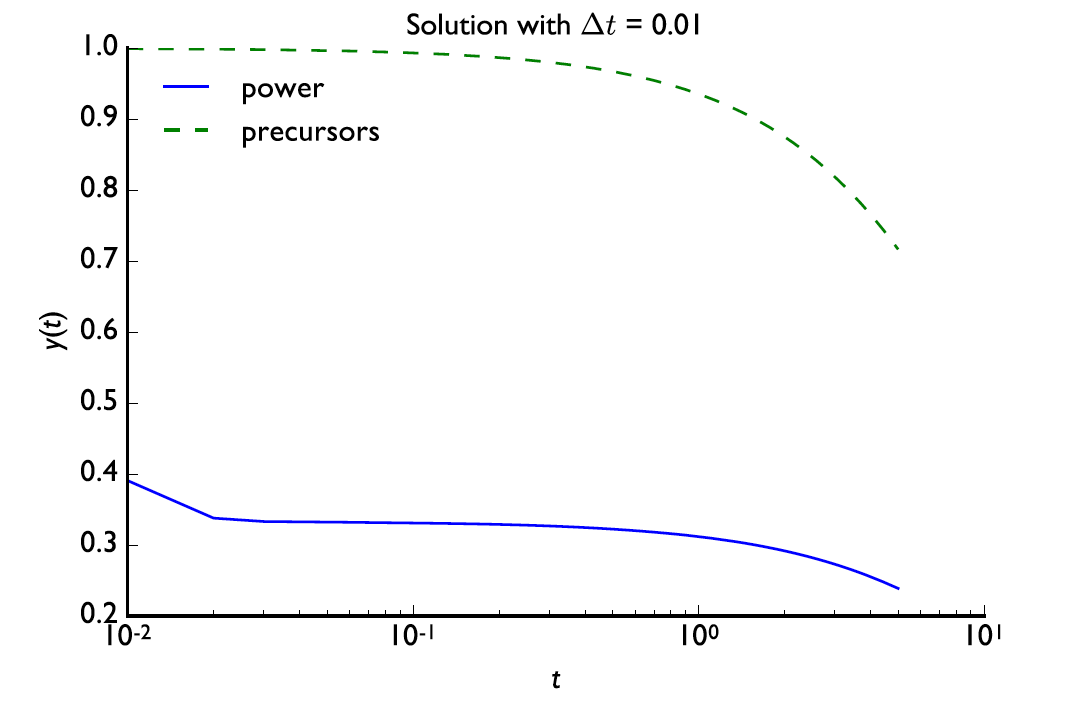

Yes, backward Euler works with this time step size, where RK4 could not. It is here that we
see the benefit of implicit methods: with backward Euler we need 10 times fewer time steps
to get the solution. The price of this was that we had to solve a linear system at each step.

### Linear Reactivity Ramp

In this case we will insert positive reactivity linearly, this could be done by slowly removing
a control rod, and see what happens. We will have a linear ramp between $\rho = 0$ and
$\rho = 0.5$ \\$ over 1 second.

In [19]:
#reactivity function
rho = lambda t: (t<1)*beta*0.5*t + beta*0.5*(t>=1)

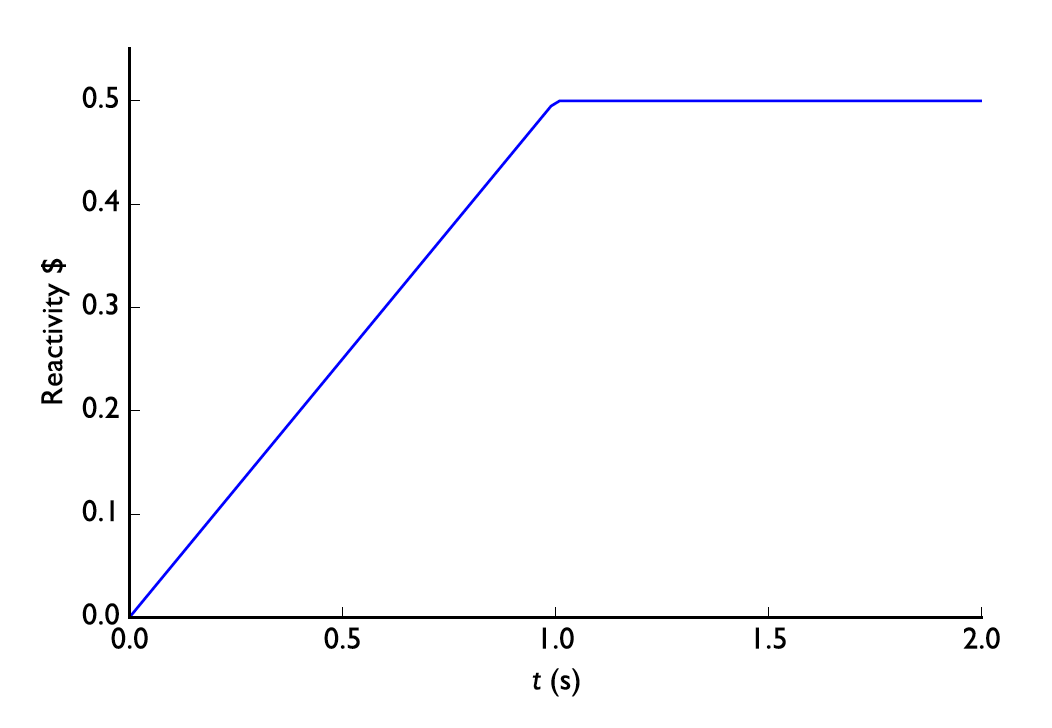

The solution with backward Euler demonstrates two different growth rates: one corresponding
to the ramp, and another once the reactivity stops increasing.

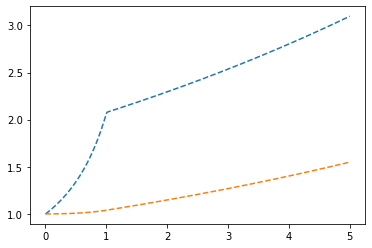

In [23]:
import numpy as np
#Set up A
beta = 705.0e-5
Lambda = 2.0e-5 #s
l = 1.0e-1 #s**-1
#reactivity function
#rho = lambda t: (t<1)*beta*0.5*t-beta*2.0*(1<=t<2)+beta*0.0*(t>=2)
Afunc = lambda t: np.array([(((t<1)*beta*0.5*t + beta*0.5*(t>=1)-beta)/Lambda,l),(beta/Lambda,-l)])
#set up c
c = lambda t: np.zeros(2)
#set up inital vector
y0 = np.array([1,beta/(l*Lambda)])
Delta_t = 0.001 #1 millisecond
t_final = 5
t,y = backward_euler_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[0]/y0[0],'--',label="Power")
plt.plot(t,y[1]/y0[1],'--',label="Precursors")
#plt.xscale('log')

To make the scenariomore complicated we will now look at a positive reactivity ramp that
then has the control rod completely re-inserted at $t = 1$, and then instantly brought back to
critical at $t = 2$. The reactivity for this scenario looks like:

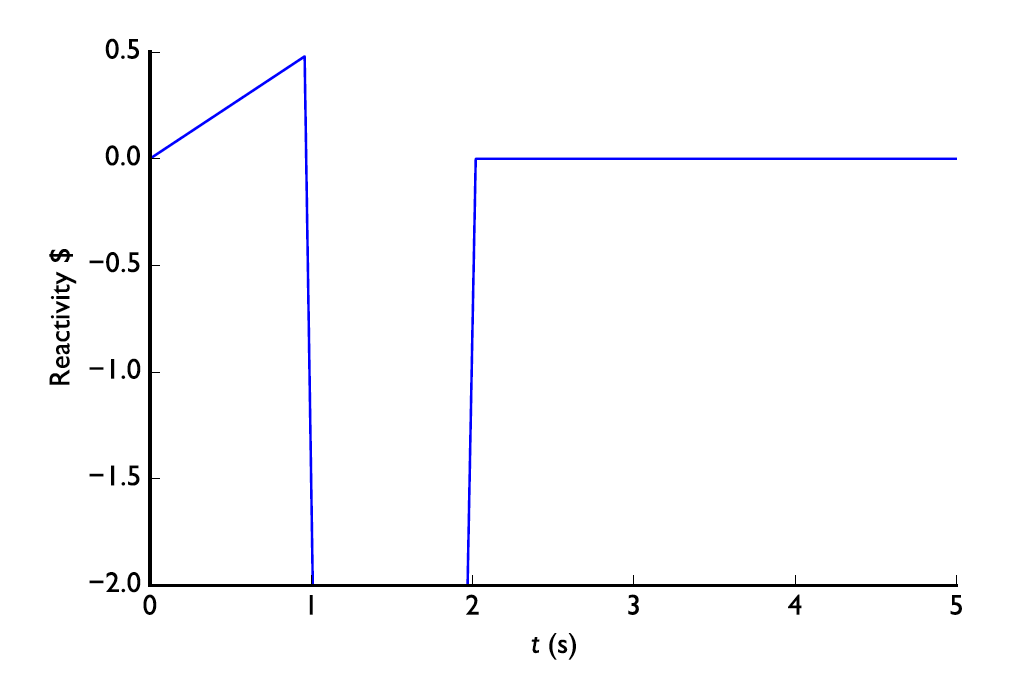

We will compare backward Euler and RK4 on this problem with the same time step.

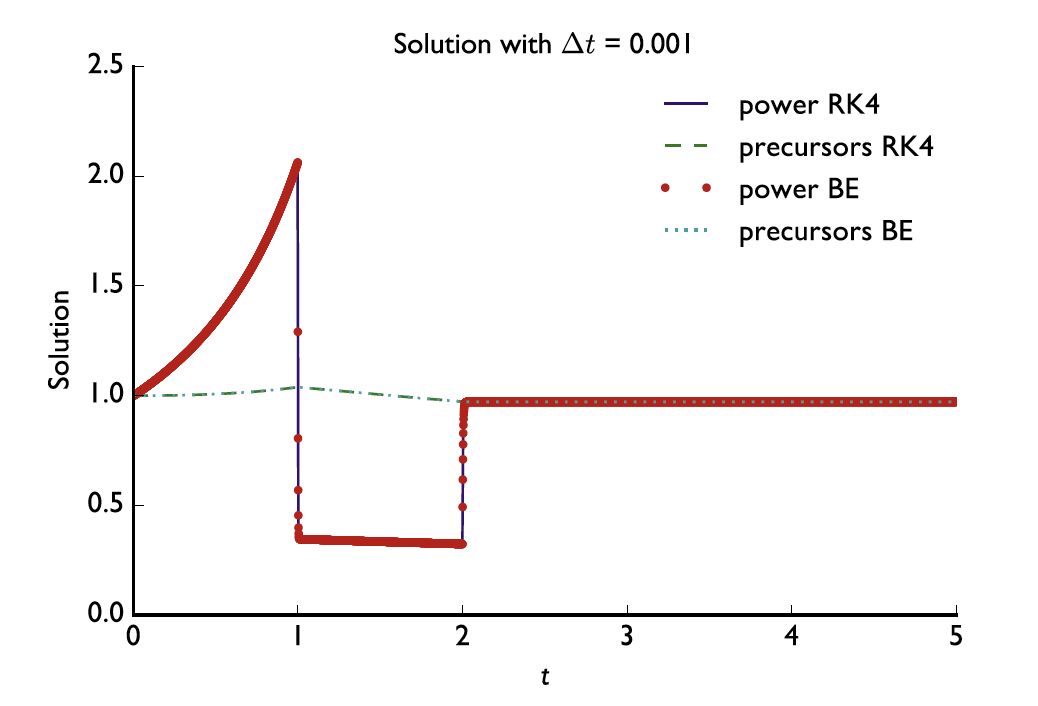

The prompt jump is a wild phenomenon: the solution changes very rapidly during it and
the methods __still keep up__ with a small enough time step. In this example, we cannot see on
the graph a difference between the solutions. Additionally, the precursors change very slowly
over the entire simulation.

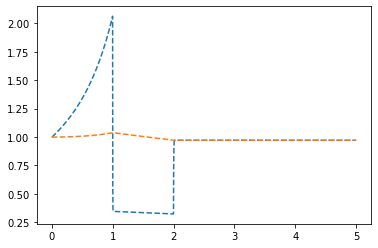

In [24]:
import numpy as np
#Set up A
beta = 705.0e-5
Lambda = 2.0e-5 #s
l = 1.0e-1 #s**-1
#reactivity function
#rho = lambda t: (t<1)*beta*0.5*t-beta*2.0*(1<=t<2)+beta*0.0*(t>=2)
Afunc = lambda t: np.array([(((t<1)*beta*0.5*t-beta*2.0*(1<=t<2)+beta*0.0*(t>=2)-beta)/Lambda,l),(beta/Lambda,-l)])
#set up c
c = lambda t: np.zeros(2)
#set up inital vector
y0 = np.array([1,beta/(l*Lambda)])
Delta_t = 0.001 #1 millisecond
t_final = 5
t,y = backward_euler_system(Afunc,c,y0,Delta_t,t_final/Delta_t)
plt.plot(t,y[0]/y0[0],'--',label="Power")
plt.plot(t,y[1]/y0[1],'--',label="Precursors")
#plt.xscale('log')